# SGPS Molecular Techniques
## Exercise 3: Working with genome-wide gene expression data
### Comparing gene expression of naive, LPS and IFNy treated monocytes.
+ Data from this paper:
+ Fairfax, BP et al. Innate Immune Activity Conditions the Effect of Regulatory Variants upon Monocyte Gene Expression. Science 343,1246949(2014).
#### First look: just one gene - TNF from the genome wide expression dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Get the data in
expr_all = pd.read_csv('monocyte_all_expression.csv', index_col=0)
expr_all

,RERE,PHF7,BCAP29,PAPD4,SDS,ZNF768,F3,LIN52,SLC9A1,CD164,...,GRHPR,CHRNB1,TBC1D4,C4orf48,BX107598,UGCGL1.1,VPS72,AW296529,CC2D1A,ARHGAP30.2
2_Untreated,9.790441,7.300656,8.956566,11.037554,6.983523,7.555529,7.147966,7.577059,9.535068,8.424032,...,8.791211,8.312185,7.833375,8.225152,7.151056,8.676772,8.410220,7.211639,7.604288,8.971266
3_Untreated,8.923455,7.284492,8.740269,10.457396,7.819850,7.477889,7.816232,7.367911,9.416581,9.101542,...,9.293750,8.206373,7.504186,8.665725,7.155556,7.899655,8.499364,7.115580,7.807368,8.279488
60_Untreated,9.865382,7.070042,8.597482,10.510448,7.272814,7.441528,7.090109,7.109993,10.013401,8.572141,...,9.060916,8.253385,7.889364,8.503173,7.156419,8.239214,8.295041,7.204468,7.731997,9.018779
61_Untreated,9.467094,7.390813,8.934205,10.738276,6.859392,7.528432,6.843392,7.524393,9.936250,8.428560,...,9.062515,8.364058,7.865590,8.430069,7.131658,8.274826,8.332870,7.179752,7.530734,9.126754
62_Untreated,9.441596,7.242676,8.592481,10.648097,7.462482,7.374076,7.545064,7.134254,10.137927,8.276697,...,9.185479,8.037088,7.699464,8.743046,7.188381,7.989197,8.433115,7.434024,7.756521,8.884357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426_LPS24h,9.742062,7.059988,8.657487,10.805615,5.304757,7.734733,6.871390,7.228963,11.060412,8.532747,...,8.478067,8.202240,7.467128,8.352854,7.242027,7.940360,8.683181,7.258820,7.810266,9.251630
429_LPS24h,10.192514,7.236008,8.676955,10.871828,5.051904,7.545954,6.913059,7.279411,10.805543,8.470332,...,8.466433,8.291509,7.430134,8.253408,7.182041,8.106536,8.723068,7.339259,7.620997,9.446402
430_LPS24h,9.244622,7.174317,8.897469,10.797612,5.579165,7.473409,7.008846,7.205574,10.703488,8.823769,...,8.589745,8.162072,7.529747,8.510888,7.243233,8.073605,8.273130,7.132539,7.756732,8.964569
431_LPS24h,9.625692,7.160371,8.918702,10.878961,5.737182,7.622804,7.145538,7.159781,10.566232,8.520005,...,8.821055,8.202816,7.367815,8.306160,7.284322,8.147883,8.354880,7.187291,7.769379,8.937714


In [3]:
912/4

228.0

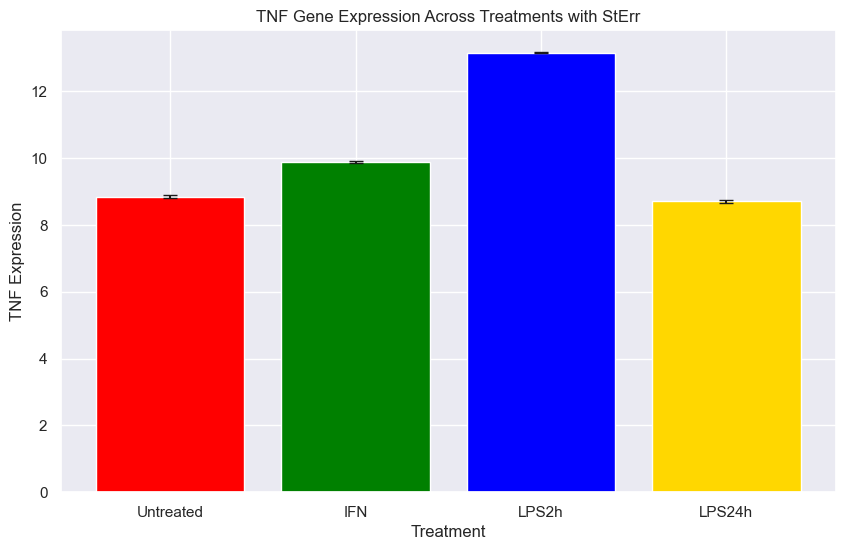

In [4]:
# Extract TNF data and the treatments
expr_tnf = expr_all[['TNF']].copy()
expr_tnf['Treatment'] = [idx.split('_')[-1] for idx in expr_tnf.index]

# Group by treatment and calculate mean and standard error
tnf_grouped = expr_tnf.groupby('Treatment').agg(['mean', 'std'])
tnf_grouped.columns = ['Mean', 'StDev']

# Number of replicates
n_replicates = 228
tnf_grouped['StErr'] = tnf_grouped['StDev'] / np.sqrt(n_replicates)

# Define the correct order and colors
labels = ['Untreated', 'IFN', 'LPS2h', 'LPS24h']
colours = ['red', 'green', 'blue', 'gold']

# Reorder the dataframe according to the specified order
tnf_grouped = tnf_grouped.reindex(labels)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, 
       tnf_grouped['Mean'], 
       yerr=tnf_grouped['StErr'], 
       color=colours, 
       capsize=5)

ax.set_xlabel('Treatment')
ax.set_ylabel('TNF Expression')
ax.set_title('TNF Gene Expression Across Treatments with StErr')

plt.show()

## Working with all the gene expression data
## Looking at dimension reduction, using principal component analysis

In this dataset we have:
    - 228 donors, ~15000 gene expression values

The gene expression is from the innate immune cells, monocytes under 4 conditions:
    - Untreated, as a control.
    - Treated with inteferon-gamma (IFN) for 24 hours – a good model for viral infections.
    - Treated with Lipopolysaccharide (LPS) for 2 hours - LPS is a major component of the outer wall of gram negative bacteria, which our body registers as a toxin and elicits a strong immune response.
    - Treated with Lipopolysaccharide (LPS) for 24 hours.
    
So we have a dataset for 912 samples (from 228 donors for 4 conditions each), gene expression data for ~15,000 genes. 

How to understand this dataset?

No doubt there is high redundancy amongst the samples, so reducing them from ~15000 to a smaller number could be really helpful into interpreting the dataset (in this case for projecting the gene expression and genes into one value for each sample for each principal component).



In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
sns.set_context("poster")

In [6]:
# Get the data in
expr_all = pd.read_csv('monocyte_all_expression.csv', index_col=0)

In [7]:
# See what it looks like
expr_all


,RERE,PHF7,BCAP29,PAPD4,SDS,ZNF768,F3,LIN52,SLC9A1,CD164,...,GRHPR,CHRNB1,TBC1D4,C4orf48,BX107598,UGCGL1.1,VPS72,AW296529,CC2D1A,ARHGAP30.2
2_Untreated,9.790441,7.300656,8.956566,11.037554,6.983523,7.555529,7.147966,7.577059,9.535068,8.424032,...,8.791211,8.312185,7.833375,8.225152,7.151056,8.676772,8.410220,7.211639,7.604288,8.971266
3_Untreated,8.923455,7.284492,8.740269,10.457396,7.819850,7.477889,7.816232,7.367911,9.416581,9.101542,...,9.293750,8.206373,7.504186,8.665725,7.155556,7.899655,8.499364,7.115580,7.807368,8.279488
60_Untreated,9.865382,7.070042,8.597482,10.510448,7.272814,7.441528,7.090109,7.109993,10.013401,8.572141,...,9.060916,8.253385,7.889364,8.503173,7.156419,8.239214,8.295041,7.204468,7.731997,9.018779
61_Untreated,9.467094,7.390813,8.934205,10.738276,6.859392,7.528432,6.843392,7.524393,9.936250,8.428560,...,9.062515,8.364058,7.865590,8.430069,7.131658,8.274826,8.332870,7.179752,7.530734,9.126754
62_Untreated,9.441596,7.242676,8.592481,10.648097,7.462482,7.374076,7.545064,7.134254,10.137927,8.276697,...,9.185479,8.037088,7.699464,8.743046,7.188381,7.989197,8.433115,7.434024,7.756521,8.884357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426_LPS24h,9.742062,7.059988,8.657487,10.805615,5.304757,7.734733,6.871390,7.228963,11.060412,8.532747,...,8.478067,8.202240,7.467128,8.352854,7.242027,7.940360,8.683181,7.258820,7.810266,9.251630
429_LPS24h,10.192514,7.236008,8.676955,10.871828,5.051904,7.545954,6.913059,7.279411,10.805543,8.470332,...,8.466433,8.291509,7.430134,8.253408,7.182041,8.106536,8.723068,7.339259,7.620997,9.446402
430_LPS24h,9.244622,7.174317,8.897469,10.797612,5.579165,7.473409,7.008846,7.205574,10.703488,8.823769,...,8.589745,8.162072,7.529747,8.510888,7.243233,8.073605,8.273130,7.132539,7.756732,8.964569
431_LPS24h,9.625692,7.160371,8.918702,10.878961,5.737182,7.622804,7.145538,7.159781,10.566232,8.520005,...,8.821055,8.202816,7.367815,8.306160,7.284322,8.147883,8.354880,7.187291,7.769379,8.937714


In [8]:
# Get the treatment for each sample
y = []
for item in expr_all.index.values:
    if 'Untreated' in item:
        y.append(0)
    elif 'IFN' in item:
        y.append(1)
    elif 'LPS2h' in item:
        y.append(2)
    elif 'LPS24h' in item:
        y.append(3)
    else:
        print('Error: Data from non-recognisable experiment')
y = np.array(y)

labels = ['Untreated', 'IFN', 'LPS 2h', 'LPS 24h']
colours = ['red', 'green', 'blue', 'gold']

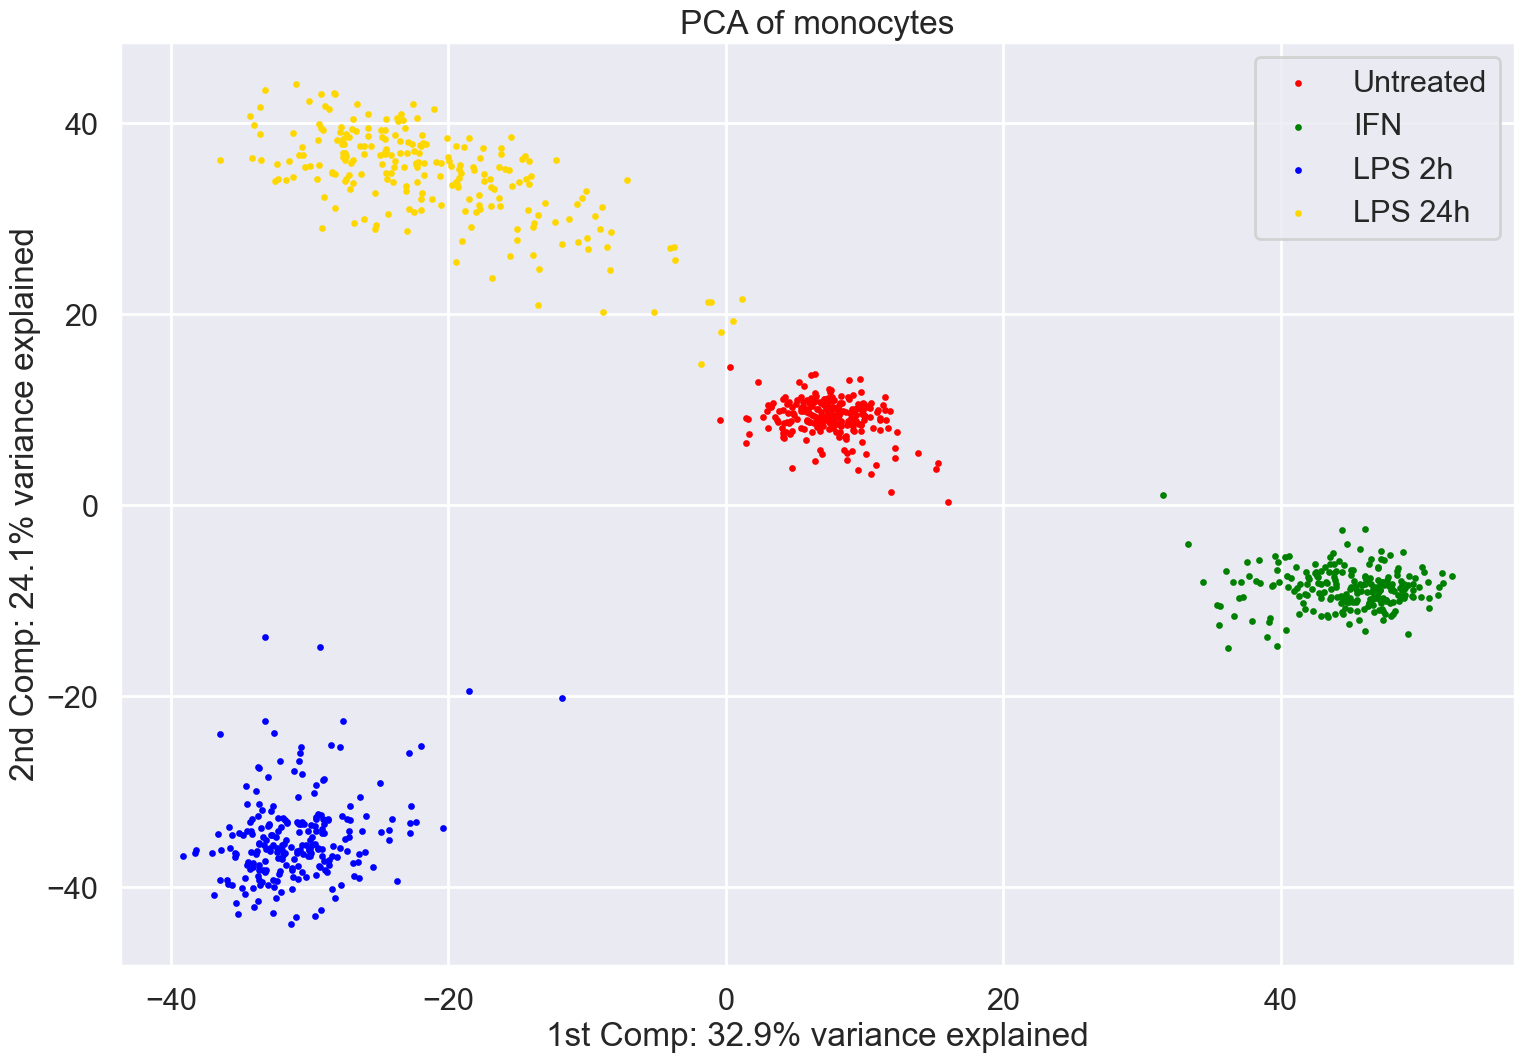

In [9]:
# PCA of component 1 and 2
pca = PCA()
X_pca = pca.fit_transform(expr_all)
var_expl = pca.explained_variance_ratio_
r_col = []
fig = plt.figure(figsize=(18,12))
for colour, i, target_name in zip(colours, range(len(labels)), labels):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], s= 8, color=colour, lw=2, label=target_name)

plt.title("PCA of monocytes")
plt.legend(loc=1, shadow=False)
# plt.axis([-4, 4, -1.5, 1.5])
plt.xlabel('1st Comp: ' + str(round(var_expl[0]*100,1)) + '% variance explained')
plt.ylabel('2nd Comp: ' + str(round(var_expl[1]*100,1)) + '% variance explained')
fig.savefig('PCA_Extreme_Data_comp1_comp2.pdf')
plt.show()

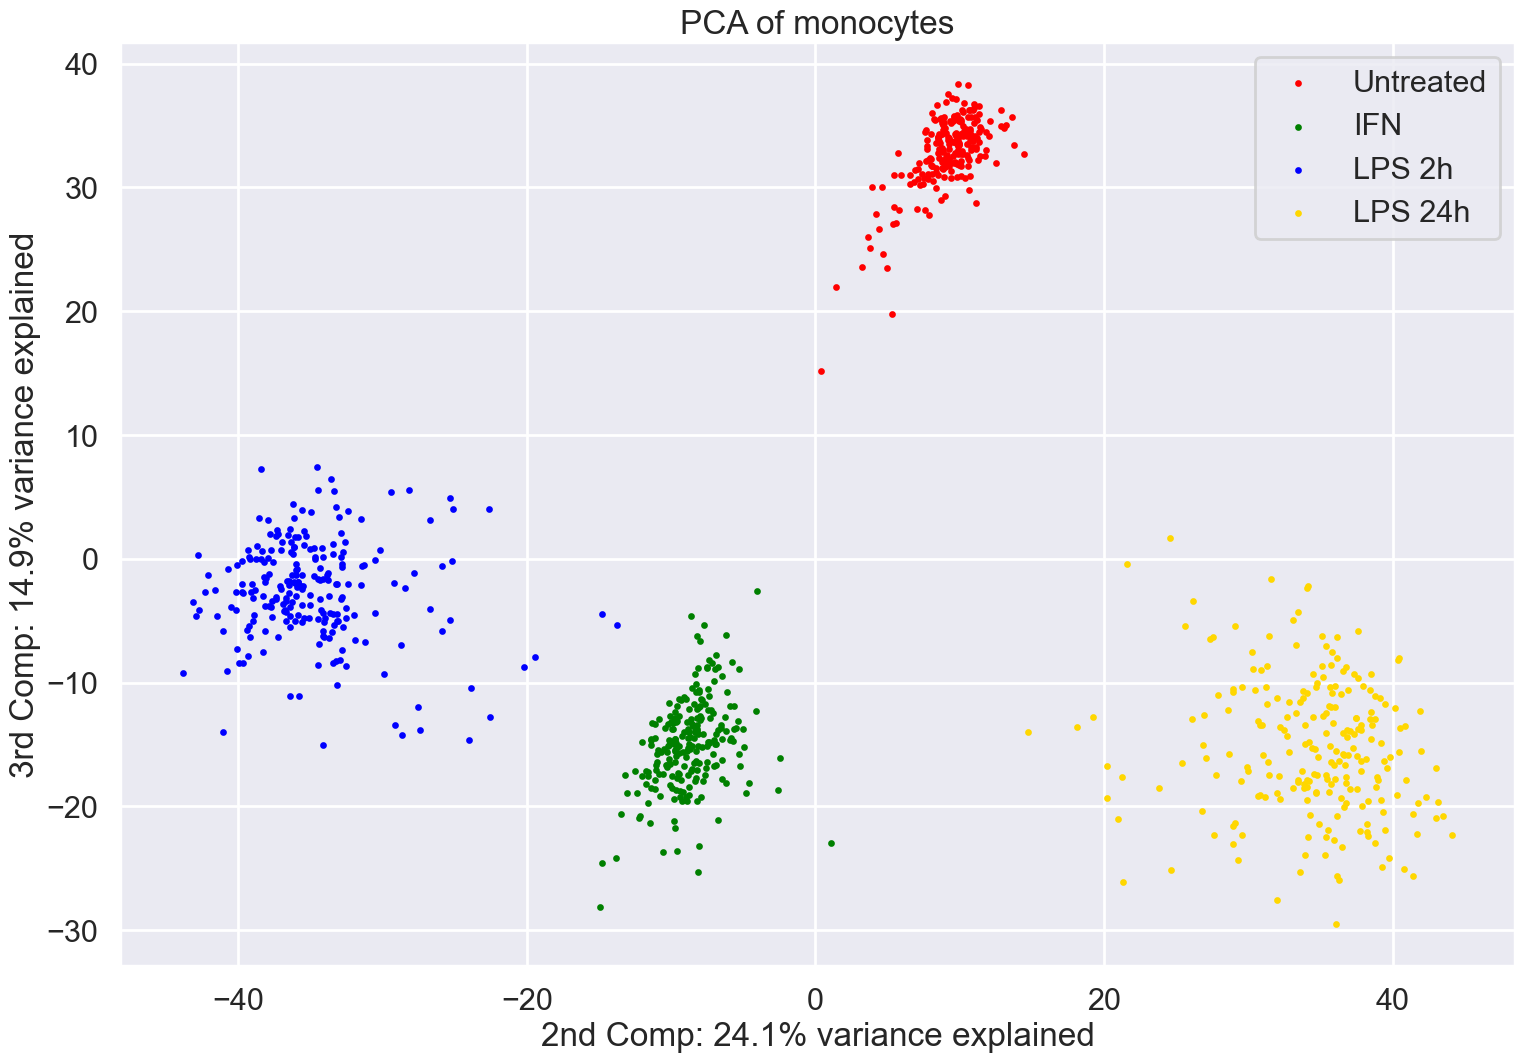

In [10]:
# PCA of component 2 and 3
fig = plt.figure(figsize=(18,12))
for colour, i, target_name in zip(colours, range(len(labels)), labels):
    plt.scatter(X_pca[y == i, 1], X_pca[y == i, 2], s= 8, color=colour, lw=2, label=target_name)

plt.title("PCA of monocytes")
plt.legend(loc=1, shadow=False)
# plt.axis([-4, 4, -1.5, 1.5])
plt.xlabel('2nd Comp: ' + str(round(var_expl[1]*100,1)) + '% variance explained')
plt.ylabel('3rd Comp: ' + str(round(var_expl[2]*100,1)) + '% variance explained')
fig.savefig('PCA_Extreme_Data_comp2_comp3.pdf')
plt.show()

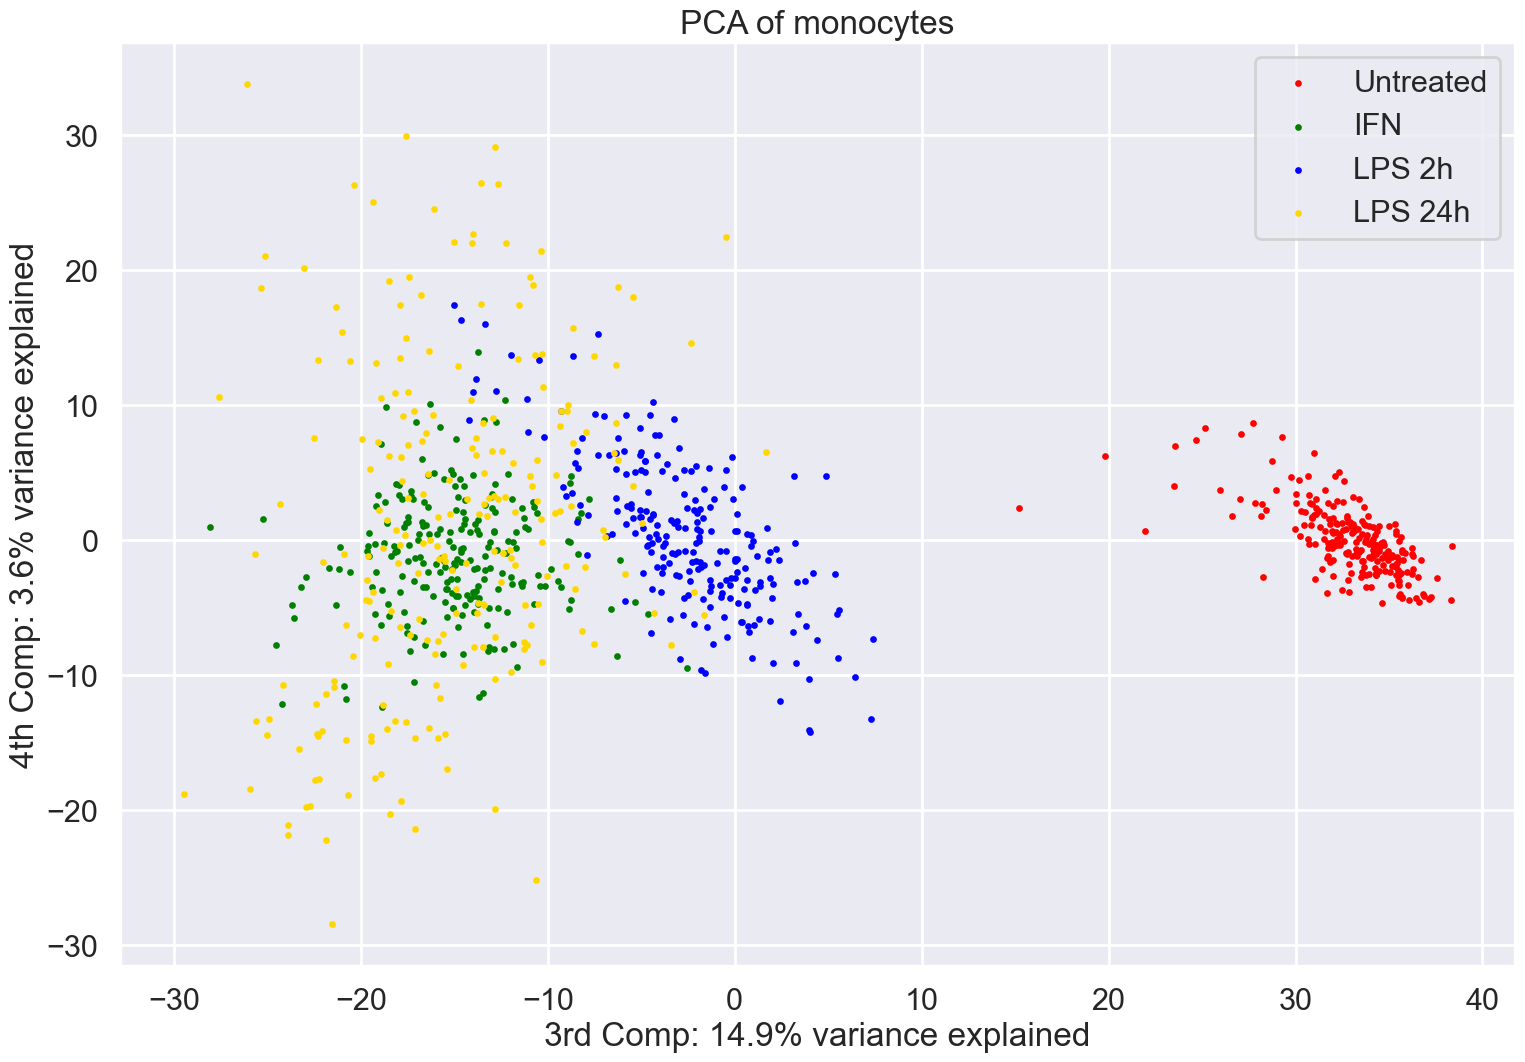

In [11]:
# PCA of component 3 and 4
fig = plt.figure(figsize=(18,12))
for colour, i, target_name in zip(colours, range(len(labels)), labels):
    plt.scatter(X_pca[y == i, 2], X_pca[y == i, 4], s= 8, color=colour, lw=2, label=target_name)

plt.title("PCA of monocytes")
plt.legend(loc=1, shadow=False)
# plt.axis([-4, 4, -1.5, 1.5])
plt.xlabel('3rd Comp: ' + str(round(var_expl[2]*100,1)) + '% variance explained')
plt.ylabel('4th Comp: ' + str(round(var_expl[3]*100,1)) + '% variance explained')
fig.savefig('PCA_Extreme_Data_comp2_comp3.pdf')
plt.show()

In [13]:
# Get loadings for the first two components
loadings = pca.components_.T

# Creating the correct dataframe for loadings
loadings_df = pd.DataFrame(loadings, index=expr_all.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])

# Get the top and bottom 100 genes for PC1 and PC2
top_100_pc1 = loadings_df['PC1'].nlargest(100)
bottom_100_pc1 = loadings_df['PC1'].nsmallest(100)

for gene in top_100_pc1.index.values:
    print(gene)

CXCL9
RARRES3
ANKRD22
VAMP5
SERPING1
ANKRD22.1
SEPT4.1
IFI27
FAM26F
APOL3
C1QB
UBD
TNFSF10
IDO1.1
IDO1
FGL2
FZD2
C1QC
STAT1
GBP5
GBP4
GIMAP4
CEBPA
SLC6A12
HAPLN3
TLR7
CD38
IDO2
KCNE1L
MUC1.2
BP394710
WARS
GIMAP7
STAT1.1
SEPT4.2
GBP1
LMNB1
GPBAR1.1
ASCL2
C5orf20
CLEC10A.2
LGALS3BP
IL32.1
TNFSF13B
WARS.1
HSD11B1.1
LAP3
CXCL10
HSD11B1
IL8RBP
SUCNR1
STAT1.2
LAP3.1
HSD11B1.2
CD74.1
UBE2L6.1
C2
PSMB8
GIMAP5
JAK2
HERPUD1
ST3GAL5.1
IFITM1
TNFSF13B.1
UBE2L6
IFI44L
CLEC10A.1
P2RY14.2
GIMAP6
GPBAR1
PSMB8.1
SEPX1
LPAR6
TMEM109
ARHGEF3
EPSTI1
TIFAB
RERE
TAP2
ALDH1A1.1
SAMD4A
PSMB8.3
HVCN1
STAMBPL1
LY6E
POLB
TAP2.1
P2RY13
MS4A6A.2
HLA-DPB1
LRRK2.1
HERPUD1.1
CLEC10A
PDXP
C17orf87.1
C4orf32.1
HVCN1.1
MUC1.1
C16orf75
CTSC


#### Can we see what gene pathways this list is enriched in?

Try pasting these genes into Enrichr - https://maayanlab.cloud/Enrichr/
and look at:

+ Ontologies -> GO Biological Process
+ Pathways -> KEGG

If a particaular KEGG pathway is of interest, can also go further and look at it in KEGG: https://www.genome.jp/kegg/

### Clustering the data

From the PCA (well for the first-  three components), we can see a good separation between the four different treatments of the cells. Can we use clustering methods to fully classify them?

Read through this tutorial - https://realpython.com/k-means-clustering-python/ and have a go at clustering the PCA data.

In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [15]:
# Let's set K-means for 4 clusters
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [16]:
kmeans.fit(X_pca[:,:3])
kmeans.inertia_
kmeans.cluster_centers_
# Counter(kmeans.labels_)

array([[  7.45329705,   9.1751164 ,  32.88254369],
       [ 44.79198864,  -8.7069879 , -14.98120663],
       [-21.31138611,  34.37618321, -15.26474863],
       [-30.93389957, -34.84431171,  -2.63658842]])

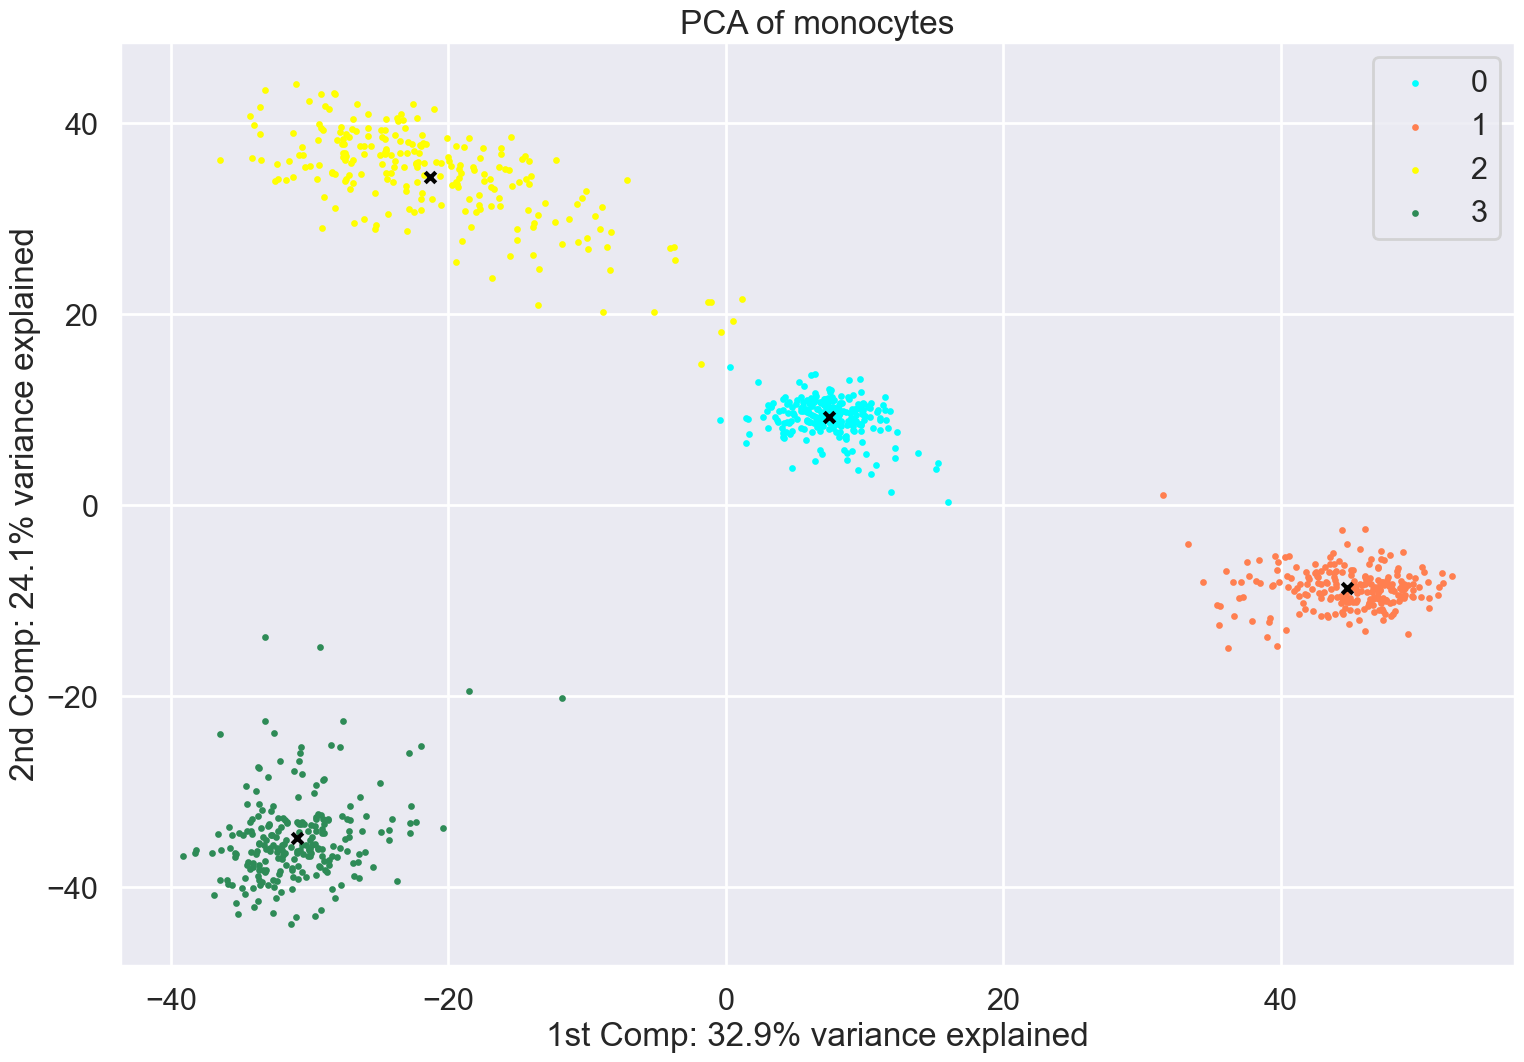

In [17]:
# Let's see how the clusters on our plot
new_colours = ['aqua', 'coral', 'yellow', 'seagreen']
fig = plt.figure(figsize=(18,12))
for colour, i, target_name in zip(new_colours, range(4), range(4)):
    plt.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], s= 8, color=colour, lw=2, label=target_name)
    plt.scatter(kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1],s=58, color='black', marker='x')

plt.title("PCA of monocytes")
plt.legend(loc=1, shadow=False)
# plt.axis([-4, 4, -1.5, 1.5])
plt.xlabel('1st Comp: ' + str(round(var_expl[0]*100,1)) + '% variance explained')
plt.ylabel('2nd Comp: ' + str(round(var_expl[1]*100,1)) + '% variance explained')
fig.savefig('PCA_Extreme_Data_comp1_comp2_with_clusters.pdf')
plt.show()

Instead of relying on th PCA, can we use clustering methods on all the data to fully classify them?

In [18]:
kmeans.fit(expr_all)
Counter(kmeans.labels_)

Counter({0: 228, 1: 228, 3: 228, 2: 228})

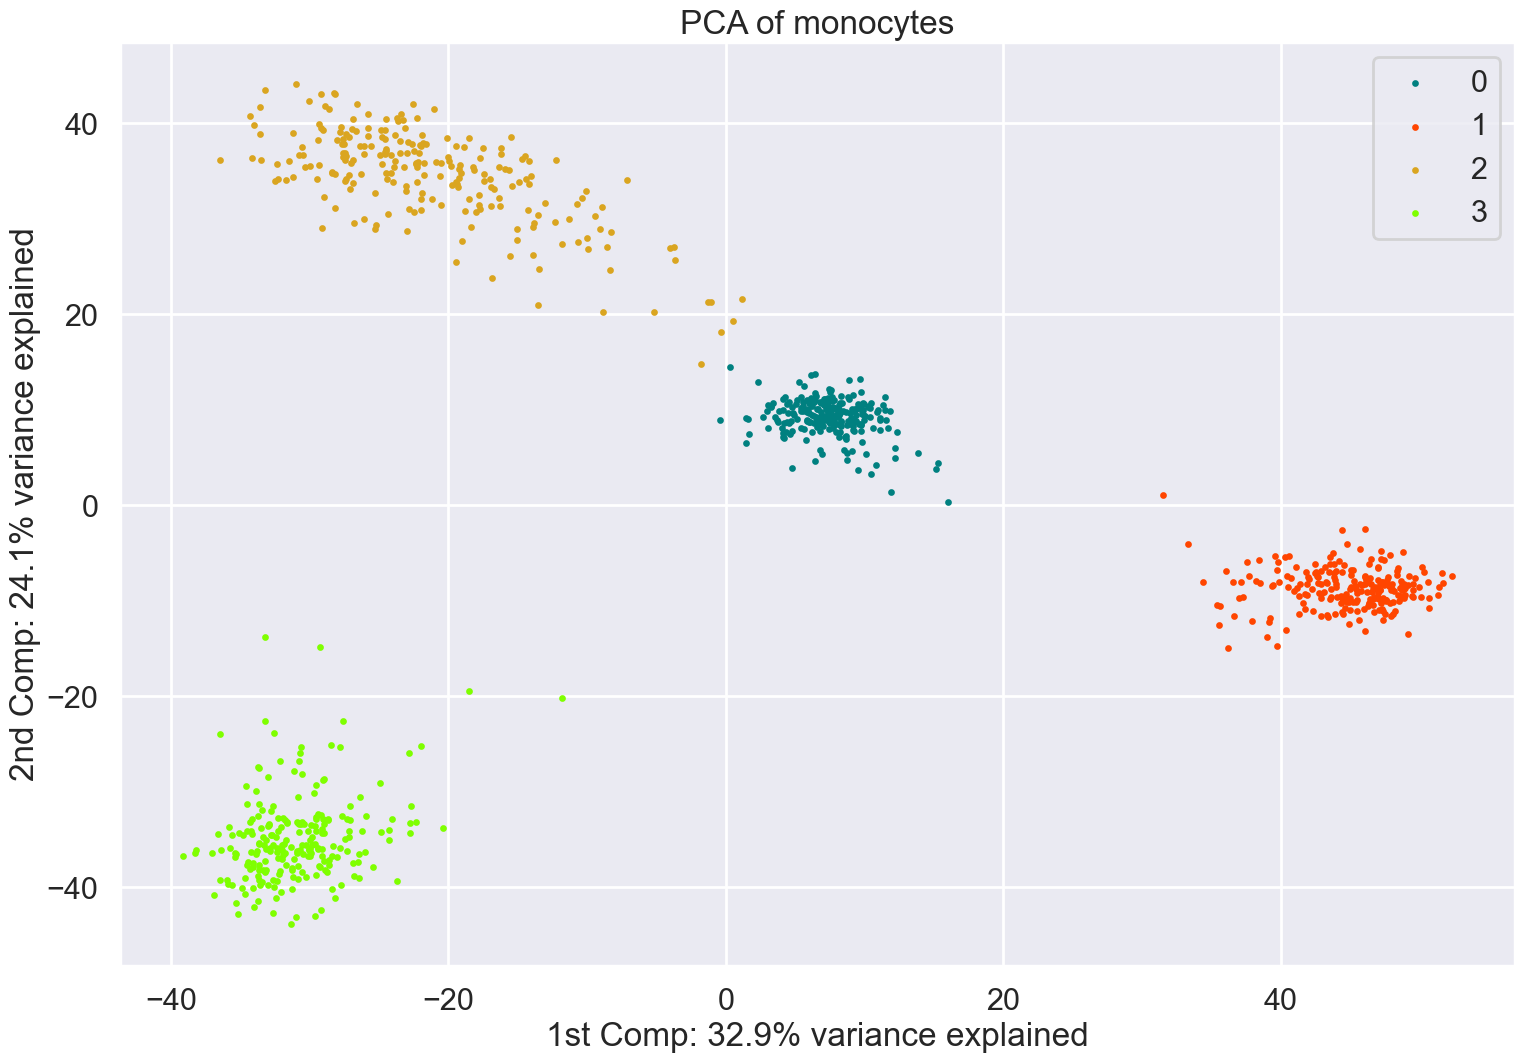

In [19]:
# Let's see how the clusters on our plot
new_colours = ['teal', 'orangered', 'goldenrod', 'chartreuse']
fig = plt.figure(figsize=(18,12))
for colour, i, target_name in zip(new_colours, range(4), range(4)):
    plt.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], s= 8, color=colour, lw=2, label=target_name)

plt.title("PCA of monocytes")
plt.legend(loc=1, shadow=False)
# plt.axis([-4, 4, -1.5, 1.5])
plt.xlabel('1st Comp: ' + str(round(var_expl[0]*100,1)) + '% variance explained')
plt.ylabel('2nd Comp: ' + str(round(var_expl[1]*100,1)) + '% variance explained')
fig.savefig('PCA_Extreme_Data_comp1_comp2_with_clusters.pdf')
plt.show()

In [20]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,